#  Предсказание температуры стали

### Содержание
- [Описание проекта](#id_description)
- [Используемые функции](#id_user_functions)
  - [Функции раздела "Обзор данных"](#id_descrip_func)
  - [Функции раздела "Предобработка данных"](#id_prep_func)
  - [Функции раздела "Исследовательский анализ данных"](#id_eda_func)
  - [Функции раздела "Обучение и тестирование моделей"](#id_learn_func)
- [Обзор данных](#id_data_survey)
  - [Файл `data_arc.csv` — данные об электродах](#id_arc)
  - [Файл `data_temp.csv` — результаты измерения температуры](#id_temp)
  - [Файл `data_gas.csv` — данные о продувке сплава газом](#id_gas)
  - [Файл `data_bulk.csv` — данные о подаче сыпучих материалов (объём)](#id_bulk)
  - [Файл `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время)](#id_bulk_time)  
  - [Файл `data_wire.csv` — данные о проволочных материалах (объём)](#id_wire)
  - [Файл `data_wire_time.csv` — данные о проволочных материалах (время)](#id_wire_time)
  - [Выводы по разделу](#id_conclusion_survey)
- [Предобработка данных](#id_preproccessing)
  - [Вывод по разделу](#id_conclusion_preproc)
- [Исследовательский нализ данных](#id_eda)
  - [Вывод по разделу](#id_conclusion_eda)
- [Обучение и тестирование моделей](#id_learning)
  - [Константная модель](#id_learn_const)
  - [Линейная регрессия](#id_learn_linreg)
  - [Случайный лес](#id_learn_forest)
  - [CatBoostRegressor](#id_learn_catboost)
- [Анализ моделей](#id_analysis)
  - [Вывод по разделу](#id_conclusion_learn)
- [Отчет](#id_report)

### Описание проекта
<a id="id_description"></a>

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Наобходимо построить модель, которая будет предсказывать температуру стали. Это позволит комбинату значительно экономить электроэнергию которая тратится на нагрев стали.

Необходимо получить значение мертики MAE выше 8.7 единиц.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Цель**

Построить модель, которая предскажет температуру стали.

In [296]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor


import warnings
warnings.filterwarnings("ignore")

In [297]:
# Загрузка файлов
try:
    # Локальный путь 
    arc       = pd.read_csv('final_steel_data/data_arc.csv')
    bulk      = pd.read_csv('final_steel_data/data_bulk.csv')
    bulk_time = pd.read_csv('final_steel_data/data_bulk_time.csv')
    gas       = pd.read_csv('final_steel_data/data_gas.csv')
    temp      = pd.read_csv('final_steel_data/data_temp.csv')
    wire      = pd.read_csv('final_steel_data/data_wire.csv')
    wire_time = pd.read_csv('final_steel_data/data_wire_time.csv')
except:
    # Серверный путь
    arc       = pd.read_csv('/datasets/final_steel/data_arc.csv')
    bulk      = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    gas       = pd.read_csv('/datasets/final_steel/data_gas.csv')
    temp      = pd.read_csv('/datasets/final_steel/data_temp.csv')
    wire      = pd.read_csv('/datasets/final_steel/data_wire.csv')
    wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Используемые функции
<a id="id_user_functions"></a>

##### Функции раздела "Обзор данных"
<a id="id_descrip_func"></a>

In [299]:
'''
Фукция для исследовательского анализа данных
  Входные данные - имя датасета,
                 - анализируемый датасет
                 - размет выводимого рисунка
  Выводит - первые 5 строк датасета,
          - таблицу с информацией
          - количесво дубликатов
          - описательную статистику
          - график «ящик с усами» по колонкам
'''

def eda(name,df,figsize):
    start = "\033[1m"
    end = "\033[0;0m"
    print(f'{start}Исследовательский анализ данных датасета {name}:\n{end}')
    # Вывод датасета
    print(f'{start}Первые 5 строк датасета {name}:{end}')
    display(df.head())
    print()
    # Информация по датасету
    print(f'{start}Информация по датасету {name}:{end}')
    print(df.info())
    print()
    # Провека на дубликаты
    print(f'{start}Количесво дубликатов в датасете {name}:{end}')
    print(df.duplicated().sum())
    print()
    # Описательная статистика датасета
    print(f'{start}Описательная статистика датасета {name}:{end}')
    display(df.describe())
    print()
    # график «ящик с усами»
       # параметры
    list_not_object_columns = list(df.select_dtypes(exclude='object').columns)
    list_not_object_columns.remove('key')
    num_not_object_columns = len(list_not_object_columns)    
       # построение графиков
    plt.figure(figsize=fig_size)
    for i in range(num_not_object_columns):
        plt.subplot(1,num_not_object_columns,i+1)
        df.boxplot(column=list_not_object_columns[i],grid=True)
    plt.suptitle(f'График «ящик с усами» для датасета {name}')
    plt.tight_layout()
    plt.show()

##### Функции раздела "Предобработка данных"
<a id="id_prep_func"></a>

In [300]:
'''
Фукция для удаления партий с нерелевантными данными
Входные данные  - имя датасета,
                - датасет
Возвращает датасет после удаления данных
'''
def delete_bad_keys(name,df):
    print(f'Количество партий в датасете {name} до удаления нерелевантных данных:', len(set(df['key'])))
    df = df[~df['key'].isin(keys_to_delete)]
    print(f'Количество партий в датасете {name} после удаления  нерелевантных данных:', len(set(df['key'])))
    return df

In [301]:
'''
Функция для проветки данных на соответсвие 
Входные данные  - имя датасета,
                - датасет
Для каждой колонки функция водит на экран:
     - название колонки 
     - количесво непустых строк в колонке в датасете 1
     - количесво непустых строк в колонке в датасете 1, при условии, 
       что в датасете 2 этаже строка, для колонки с тем же названием же не пустая
Важно: функция работает только датасетами с одинаковыми колонками
'''
def data_check(name1,df1,name2,df2):
    print(f'Проверка данных на соответствие в датасетах {name1} и {name2}')
    for column in df1.columns:
        if column != 'key':
            print(column,' \t',
                  len(df1[df1[column].isna() == False][column]),'\t\t',
                  len(df1.loc[(df1[column].isna() == False) & (df2[column].isna() == False)][column]))
        else:
            print(f'Добавка \tNot NaN in {name1} \tNot NaN in {name1}&{name2}')


##### Функции раздела "Исследовательский анализ данных"
<a id="id_eda_func"></a>


In [302]:
def show_correlation(df):
    '''
    Функция для построения визуализации корреляции между признаками.
    Входные данные - анализируемый датасет
    Выводит heatmap корреляции колонок в датасете
    '''
    plt.figure(figsize=(16,16), dpi= 80)
    sns.heatmap(
        df.corr(), xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, cmap='PiYG', center=0, annot=True, cbar=False)

    plt.title('Корреляция между признаками', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

##### Функции раздела "Анализ моделей"
<a id="id_learn_func"></a>

In [303]:
def importances(model, model_name):
    '''
    Функция для визуализации наиболее важных признаков у выбранной модели.
    '''
    model.fit(features_train, target_train)
    result = permutation_importance(model, 
                                    features_train, target_train, 
                                    scoring='neg_mean_absolute_error', n_jobs=4, random_state=120922)
    per_imp = pd.DataFrame(result.importances_mean, 
                           index=features_train.columns, 
                           columns=['permutation_importances'])
    
    per_imp.sort_values(by=['permutation_importances']).plot(
        kind='barh', title='Важность признаков для модели "{}""'.format(model_name), figsize=(8, 8)
    )
    plt.show()
    return per_imp

### Обзор данных
<a id="id_data_survey"></a>

##### Файл `data_arc.csv` — данные об электродах
<a id="id_arc"></a>

Исследовательский анализ данных датасета arc:

Первые 5 строк датасета arc:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



Информация по датасету arc:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

Количесво дубликатов в датасете arc:
0

Описательная статистика датасета arc:


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


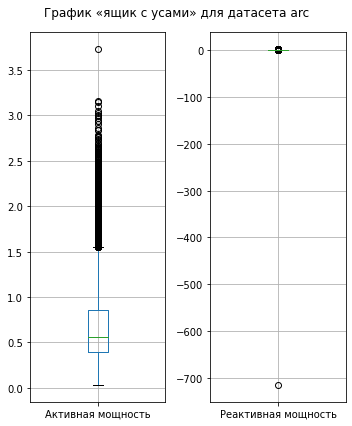

In [304]:
fig_size=(5, 6)
eda('arc',arc,fig_size)

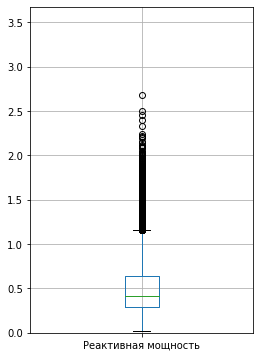

In [305]:
# Уберем выброс на графике
arc.boxplot(column='Реактивная мощность',figsize=(4,6),grid=True)
plt.ylim(0,arc['Реактивная мощность'].max()+1)
plt.show()

По схеме производственного процесс, известно что циклов нагрева несколько.
Необходимо проверить минимальное количество циклов нагрева.

In [306]:
# Группировка по номеру партии и минимальное количество циклов нагрева
arc.groupby(['key']).count().min()

Начало нагрева дугой    1
Конец нагрева дугой     1
Активная мощность       1
Реактивная мощность     1
dtype: int64

In [307]:
# Выделение номеров партий с одним нагревом
one_heat_up = arc.groupby(['key'])['Активная мощность'].count()

In [308]:
one_heat_up = one_heat_up[one_heat_up==1]
list_one_heat_up = list(one_heat_up.index)
print("Партии с только одним циклом нагревом:\n", list_one_heat_up)

Партии с только одним циклом нагревом:
 [49, 112, 246, 247, 248, 269, 343, 530, 556, 614, 661, 732, 943, 977, 1169, 1268, 1281, 1369, 1449, 1535, 1568, 1615, 1766, 1911, 1914, 1974, 1988, 2025, 2112, 2179, 2194, 2472, 2582, 2738, 2795, 2841, 3026, 3059, 3112]


**Вывод**

В датасете есть данные по времени нагрева (начало и конец нагрева) и по активной и реактивной мощности для каждого нагрева. В основном для одной партии есть несколько циклов нагрева, но есть партии всего с одним нагревом -- возможно что-то случилось на производстве, возможно сталь сразу была с нужным целевым составом.

Подробная информация по партиям с одним нагревом в другий подпунктах.

В датасете нет дубликатов, но есть явно аномальный выброс для реактивной мощности.

Распределение обоих мощностей смещенно влево.

Количество партий 3241

##### Файл `data_temp.csv` — результаты измерения температуры
<a id="id_temp"></a>

Исследовательский анализ данных датасета temp:

Первые 5 строк датасета temp:


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



Информация по датасету temp:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

Количесво дубликатов в датасете temp:
0

Описательная статистика датасета temp:


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


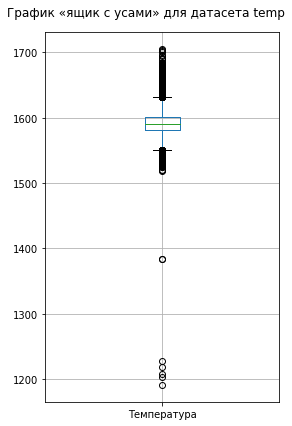

In [309]:
fig_size=(4, 6)
eda('temp',temp,fig_size)

По схеме производственного процесс, известно что замеров температур несколько.
Необходимо проверить минимальное количество замеров.

In [310]:
# Группировка по номеру партии и минимальное количество температурных данных
temp.groupby(['key']).count().min()

Время замера    1
Температура     1
dtype: int64

In [311]:
# Выделение номеров партий с одним замером температуры
one_temp = temp.groupby(['key'])['Температура'].count()

In [312]:
one_temp

key
1       5
2       6
3       5
4       3
5       2
       ..
3237    1
3238    1
3239    1
3240    1
3241    1
Name: Температура, Length: 3216, dtype: int64

In [313]:
one_temp = one_temp[one_temp==1]
list_one_temp = list(one_temp.index)
print("Партии с только одной температурой:\n", list_one_temp)

Партии с только одной температурой:
 [195, 279, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658

In [314]:
# Проверка количесва температурных данный для партий с одним циклом нагрева
temp[temp['key'].isin(list_one_heat_up)].groupby('key').count()

,Время замера,Температура
key,,
49,8,8
112,5,5
246,5,5
247,4,4
248,6,6
269,4,4
343,4,4
530,2,2
556,2,2


**Вывод**

В датасете `temp` есть данные по времени замера температуры и значение температуты.
Данные имеют достаточно симметричное распределение.

Достаточно много партий имеют только одно вхождение в таблице -- 195, 279 и все партии начиная с 2500.
Здесь предположительно сломалось оборудование/датчик или вышла из строя программа -- необходимо провести расследование на производстве.

При этом даннные с одной температурой и данные с одним циклом нагрева не почти пересекаются. 
При этом для большинсва данных с одним циклом нагрева имеется несколько температурных данных. 
Что не подтверждает гипотезу что целевой состав был достигнут сразу. 
Необходимо проверить датчик и программу на производстве.

В датасете нет дубликатов, но есть выбросы с температурой около 1200 и один выброс с темепературой 1400.

Количество партий 3241

##### Файл `data_gas.csv` — данные о продувке сплава газом
<a id="id_data_gas"></a>

Исследовательский анализ данных датасета gas:

Первые 5 строк датасета gas:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Информация по датасету gas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

Количесво дубликатов в датасете gas:
0

Описательная статистика датасета gas:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


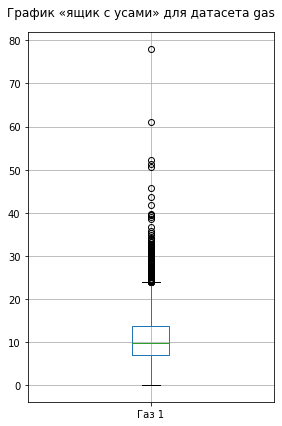

In [315]:
fig_size = (4,6)
eda('gas',gas,fig_size)

In [316]:
# Поиск отсутствующих партий
list(set(arc['key']) - set(gas['key']))

[193, 259]

**Вывод**

В датасете `gas` есть данные о первой продувке стали газом

В датасете нет дубликатов.
Распределение смещенно влево.

Количество партий 3239. Отсутствующие партии 193 и 253

Исследовательский анализ данных датасета bulk:

Первые 5 строк датасета bulk:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Информация по датасету bulk:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

Количесво дубликатов в датасете bulk:
0

Описательная статистика датасета bulk:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


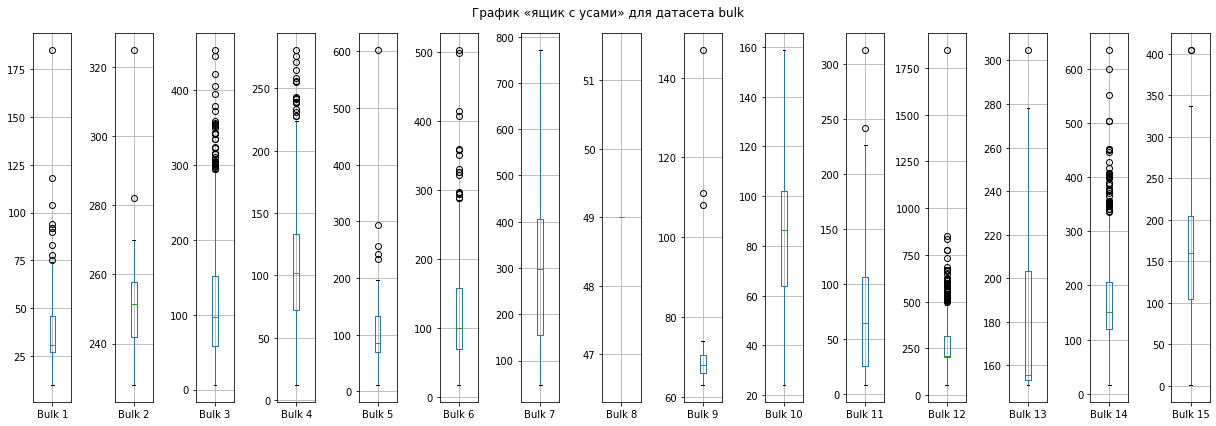

In [317]:
fig_size = (17,6)
eda('bulk',bulk,fig_size)

**Вывод**

В датасете `bulk` есть данные по количеству добавленых сыпучих материалов в сталь.

В датасете нет дубликатов.
Есть пропуски, которые означают, что такой вид материала не добавлялся -- на этапе пердобоработки пропуски заменить на нули

Отрицательных значений в объеме нет, значит, с этой точки зрения - данные релевантны.

##### Файл `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время)
<a id="id_bulk_time"></a>

In [318]:
fig_size = (17,6)
eda('bulk_time',bulk_time,fig_size)

Исследовательский анализ данных датасета bulk_time:

Первые 5 строк датасета bulk_time:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



Информация по датасету bulk_time:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

Количесво дубликатов в датасете bulk_time:
0

Описательная статистика датасета bulk_time:


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


<Figure size 1224x432 with 0 Axes>

**Вывод**

В датасете `bulk_time` данные о времени добавления сыпучих материалов

Дубликатов нет. Вероятно, эта информация лишняя, так как анализируется вся партия и фактор точного времени не важен.

##### Файл `data_wire.csv` — данные о проволочных материалах (объём)
<a id="id_wire"></a>

Исследовательский анализ данных датасета wire:

Первые 5 строк датасета wire:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Информация по датасету wire:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

Количесво дубликатов в датасете wire:
0

Описательная статистика датасета wire:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


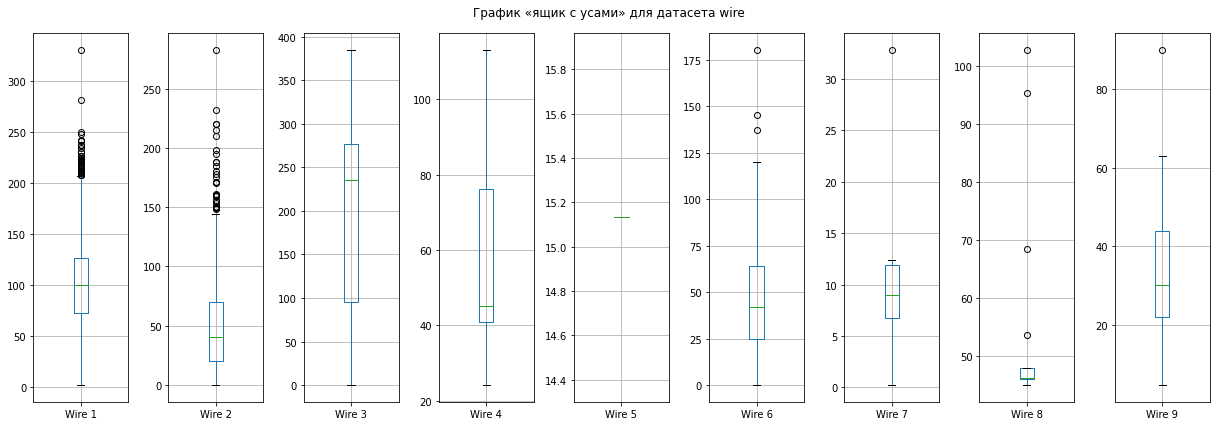

In [319]:
fig_size = (17,6)
eda('wire',wire,fig_size)

**Вывод**

В датасете `wire` есть данные по количеству добавленых проволочных материалов в сталь.

В датасете нет дубликатов.
Есть пропуски, которые означают, что такой вид материала не добавлялся -- на этапе пердобоработки пропуски заменить на нули

Отрицательных значений в объеме нет, значит, с этой точки зрения - данные релевантны.

##### Файл `data_wire_time.csv` — данные о проволочных материалах (время)
<a id="id_wire_time"></a>

In [320]:
fig_size = (17,6)
eda('wire_time',wire_time,fig_size)

Исследовательский анализ данных датасета wire_time:

Первые 5 строк датасета wire_time:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Информация по датасету wire_time:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

Количесво дубликатов в датасете wire_time:
0

Описательная статистика датасета wire_time:


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<Figure size 1224x432 with 0 Axes>

**Вывод**

В датасете `wire_time` данные о времени добавления проволочных материалов

Дубликатов нет. Вероятно, эта информация лишняя, так как анализируется вся партия и фактор точного времени не важен.

##### Вывод по разделу
<a id="id_conclusion_survey"></a>

- Данные требуют предворительной предобработки
  - Датасет `arc`. Есть партии всего с одним нагревом, приэтом у большинства этих партий несколько замеров температур. Эти данные не релевантны и требуют удаления.
  - Датасет `arc`. Выброс реактивной мощности -- отрицательное значение.
  - Датасет `temp`. Достаточно много партий имеют только одно вхождение в таблице -- 195, 279 и все партии начиная с 2500. Получается, что для всех этих партий отсутсвует целевой признак -- на таких данных модель обучать нельзя, поэтому данные требуют удаления.
  - Датасет `temp`. Выбросы температур -- несколько выбросов сослишком низкой температурой около 1200.
  - Датасет `gas`. Из технологического процесса, известно, что продувка газом обязательна -- партии с отсутсвующими данными по газу не релевантны и требуют удаленияю. Таких партий всего 2 (193 и 253).
  - Датасеты `bulk` и `wire`. Есть пропуски, которые означают, что такой вид материала не добавлялся --  заменить NaN на нули
  - Ни в одном датасете нет дубликатов
  
- Имеется лишняя информация. 
  Так как анализируется вся партия и фактор точного времени не важен, датасеты с временем подачи сыпучих и проволочных материалов (`bulk_time`, `wire_time`) для дальнейшей работы не нужны.


Из предварительного собрания (13.09.2022) изветсно, что заказчик разрешил удалить аномальные данные с отрицательной реактивной мощностью и слишком низкими температурами (~1200)

С учетом проведенного анализа и полученной информации составлени план последующей работы (представлени ниже).


**План работы**
- Предобработка данных 
   - удалить партии с одним циклом нагрева в датасете `arc`, одной температурой в датасете `temp` и без продувки газом
   - удалить данные с отрицательной реактивной мощностью и слишком низкими температурами
   - заменить пропуски на нули в `bulk` и `wire`
   - сгрупировать датасеты по номеру партии и объединить пересечением. Важно: номер партии обязательно должен присутвовать сразу 3х таблицах  `arc`, `temp`, `gas`
   
- Исследовательский анализ данных. 
  - посмотреть корреляции
  - выбрать признаки для обучения модели, возможно добавить новые.
    Возможно время нагрева, полная мощность.
    Важно: не допустить утечки целевого признака
    
- Обучение и тестирование моделей    
   - выделить целевой признак -- конечную температуру
   - определиться какие модели лучше использовать
   - разделить данные на тестовую и обучающую выборки
   - масштабировать данные
   - провести обучение с кросс-валидацией и тест лучшей модели
   - сравнить с константной моделью

- Написать отчет  



### Предобработка данных 
<a id="id_preproccessing"></a>

1. Удалить партии с одним циклом нагрева в датасете arc, одной температурой в датасете temp и без продувки газом
2. Удалить данные с отрицательной реактивной мощностью и слишком низкими температурами

In [321]:
# Создание списка партий с неполными данными и выбросами
list_no_gas = list(set(arc['key']) - set(gas['key']))
list_negative_power = list(arc[arc['Реактивная мощность'] < 0]['key'])
list_low_temperatures = list(temp[temp['Температура'] < 1400]['key'])

keys_to_delete = list(set(list_one_heat_up) | 
                      set(list_one_temp) | 
                      set(list_no_gas) | 
                      set(list_negative_power) | 
                      set())

keys_to_delete.sort()

In [322]:
list_low_temperatures

[867, 1214, 1619, 1818, 1818, 2052, 2561]

In [323]:
# удаление партий из датасетов
arc = delete_bad_keys('arc',arc)
temp = delete_bad_keys('temp',temp)
gas = delete_bad_keys('gas',gas)
bulk = delete_bad_keys('bulk',bulk)
bulk_time = delete_bad_keys('bulk_time',bulk_time)
wire = delete_bad_keys('wire',wire)
wire_time = delete_bad_keys('wire_time',wire_time)

Количество партий в датасете arc до удаления нерелевантных данных: 3214
Количество партий в датасете arc после удаления  нерелевантных данных: 2440
Количество партий в датасете temp до удаления нерелевантных данных: 3216
Количество партий в датасете temp после удаления  нерелевантных данных: 2440
Количество партий в датасете gas до удаления нерелевантных данных: 3239
Количество партий в датасете gas после удаления  нерелевантных данных: 2465
Количество партий в датасете bulk до удаления нерелевантных данных: 3129
Количество партий в датасете bulk после удаления  нерелевантных данных: 2379
Количество партий в датасете bulk_time до удаления нерелевантных данных: 3129
Количество партий в датасете bulk_time после удаления  нерелевантных данных: 2379
Количество партий в датасете wire до удаления нерелевантных данных: 3081
Количество партий в датасете wire после удаления  нерелевантных данных: 2338
Количество партий в датасете wire_time до удаления нерелевантных данных: 3081
Количество парти

3. Заменить пропуски на нули в bulk и wire

In [324]:
# Проверка данных в bulk и  bulk_time на соответсвие
data_check('bulk',bulk,'bulk_time',bulk_time)

Проверка данных на соответствие в датасетах bulk и bulk_time
Добавка 	Not NaN in bulk 	Not NaN in bulk&bulk_time
Bulk 1  	 199 		 199
Bulk 2  	 13 		 13
Bulk 3  	 957 		 957
Bulk 4  	 805 		 805
Bulk 5  	 53 		 53
Bulk 6  	 435 		 435
Bulk 7  	 14 		 14
Bulk 8  	 1 		 1
Bulk 9  	 13 		 13
Bulk 10  	 143 		 143
Bulk 11  	 128 		 128
Bulk 12  	 1876 		 1876
Bulk 13  	 14 		 14
Bulk 14  	 2128 		 2128
Bulk 15  	 1708 		 1708


In [325]:
# Проверка данных в wire и wire_time на соответсвие
data_check('wire',wire,'wire_time',wire_time)

Проверка данных на соответствие в датасетах wire и wire_time
Добавка 	Not NaN in wire 	Not NaN in wire&wire_time
Wire 1  	 2315 		 2315
Wire 2  	 819 		 819
Wire 3  	 39 		 39
Wire 4  	 12 		 12
Wire 5  	 0 		 0
Wire 6  	 45 		 45
Wire 7  	 4 		 4
Wire 8  	 13 		 13
Wire 9  	 27 		 27


Сбоя в замерах нет -- все данные в порядке.

In [326]:
# Замена пропусков нулями
bulk = bulk.fillna(0)
wire = wire.fillna(0)

In [327]:
# Вывод обновленных датасетов
display(bulk.head())
display(wire.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


4. Сгрупировать датасеты по номеру партии и объединить пересечением.

Датасет `arc`

In [328]:
# Преодбразование колонок со временем к типу DateTime
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'],format='%Y-%m-%dT%H:%M:%S')
arc['Конец нагрева дугой']  = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11403 entries, 0 to 11448
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   11403 non-null  int64         
 1   Начало нагрева дугой  11403 non-null  datetime64[ns]
 2   Конец нагрева дугой   11403 non-null  datetime64[ns]
 3   Активная мощность     11403 non-null  float64       
 4   Реактивная мощность   11403 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 534.5 KB


Добавим дополнителные признаки в датасет:
  - время нагрева в секундах 
  - полная мощность ($\sqrt{(P^2 + Q^2)}$, где $P$ - активная мощность, $Q$ - реактивная мощность)
  - мощностной коэффициент (($(P/Q)$, где $P$ - активная мощность, $Q$ - реактивная мощность))

In [329]:
# Время нагрева
arc['Время нагрева, секунд'] = (
                                 (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой'])
                                 .dt.total_seconds()
                                 .astype(int)
                                )

In [330]:
# Полная мощность
arc['Полная мощность'] =  np.sqrt(arc['Активная мощность']**2 + arc['Реактивная мощность']**2)

In [331]:
# Мощностной коэффициент
arc['Мощностной коэффициент'] =  arc['Активная мощность']/arc['Реактивная мощность']

In [332]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Время нагрева, секунд",Полная мощность,Мощностной коэффициент
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470,1.561504
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239,1.671717


In [333]:
# Группировка по номеру партии
arc_pivot = arc.pivot_table(index='key',
                            values=['Активная мощность','Реактивная мощность','Время нагрева, секунд','Полная мощность'],
                            aggfunc='sum')

arc_pivot_2 = arc.pivot_table(index='key',
                            values=['Мощностной коэффициент'],
                            aggfunc='mean')

arc_pivot = arc_pivot.join(arc_pivot_2)
arc_pivot.head()

,Активная мощность,"Время нагрева, секунд",Полная мощность,Реактивная мощность,Мощностной коэффициент
key,,,,,
1,4.878147,1098,5.826395,3.183241,1.538898
2,3.052598,811,3.649216,1.998112,1.551834
3,2.525882,655,2.989534,1.599076,1.583120
4,3.209250,741,3.814962,2.060298,1.563487
5,3.347173,869,4.035758,2.252643,1.480428


Датасет `temp`

In [334]:
# Группировка по номеру партии
temp_pivot = temp.pivot_table(index='key',
                              values='Температура',
                              aggfunc=['first','last'])
temp_pivot.columns = ['Начальная температура', 'Конечная температура']

temp_pivot.head()

,Начальная температура,Конечная температура
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


Датасет `gas`

In [335]:
# Группировка по номеру партии
gas_pivot = gas.pivot_table(index='key',
                            values=['Газ 1'],
                            aggfunc='sum')
gas_pivot.head()

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


Датасет `bulk`

In [336]:
# Группировка по номеру партии
bulk_pivot = bulk.pivot_table(index='key',
                            aggfunc='sum')
bulk_pivot.head()

,Bulk 1,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,206.0,0.0,150.0,154.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,206.0,0.0,149.0,154.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,205.0,0.0,152.0,153.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,207.0,0.0,153.0,154.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,203.0,0.0,151.0,152.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0


Датасет `wire`

In [337]:
# Группировка по номеру партии
wire_pivot = wire.pivot_table(index='key',
                            aggfunc='sum')
wire_pivot.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [338]:
# Объединение таблиц
data_final = arc_pivot.join([temp_pivot, gas_pivot, bulk_pivot, wire_pivot])
data_final.head()

,Активная мощность,"Время нагрева, секунд",Полная мощность,Реактивная мощность,Мощностной коэффициент,Начальная температура,Конечная температура,Газ 1,Bulk 1,Bulk 10,...,Bulk 9,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,4.878147,1098.0,5.826395,3.183241,1.538898,1571.0,1613.0,29.749986,0.0,0.0,...,0.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.052598,811.0,3.649216,1.998112,1.551834,1581.0,1602.0,12.555561,0.0,0.0,...,0.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.525882,655.0,2.989534,1.599076,1.583120,1596.0,1599.0,28.554793,0.0,0.0,...,0.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.209250,741.0,3.814962,2.060298,1.563487,1601.0,1625.0,18.841219,0.0,0.0,...,0.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.347173,869.0,4.035758,2.252643,1.480428,1576.0,1602.0,5.413692,0.0,0.0,...,0.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [339]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2440 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Активная мощность       2440 non-null   float64
 1   Время нагрева, секунд   2440 non-null   float64
 2   Полная мощность         2440 non-null   float64
 3   Реактивная мощность     2440 non-null   float64
 4   Мощностной коэффициент  2440 non-null   float64
 5   Начальная температура   2440 non-null   float64
 6   Конечная температура    2440 non-null   float64
 7   Газ 1                   2440 non-null   float64
 8   Bulk 1                  2379 non-null   float64
 9   Bulk 10                 2379 non-null   float64
 10  Bulk 11                 2379 non-null   float64
 11  Bulk 12                 2379 non-null   float64
 12  Bulk 13                 2379 non-null   float64
 13  Bulk 14                 2379 non-null   float64
 14  Bulk 15                 2379 non-null   

В финальной таблице есть пропущенные значения для добавок -- значит есть партии, в которые ничего не добавлялось. 
Заменим пропуски на нули. В основных колонках (нагрев, мощность, температура, газ) пропусков нет.

In [340]:
data_final = data_final.fillna(0)
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2440 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Активная мощность       2440 non-null   float64
 1   Время нагрева, секунд   2440 non-null   float64
 2   Полная мощность         2440 non-null   float64
 3   Реактивная мощность     2440 non-null   float64
 4   Мощностной коэффициент  2440 non-null   float64
 5   Начальная температура   2440 non-null   float64
 6   Конечная температура    2440 non-null   float64
 7   Газ 1                   2440 non-null   float64
 8   Bulk 1                  2440 non-null   float64
 9   Bulk 10                 2440 non-null   float64
 10  Bulk 11                 2440 non-null   float64
 11  Bulk 12                 2440 non-null   float64
 12  Bulk 13                 2440 non-null   float64
 13  Bulk 14                 2440 non-null   float64
 14  Bulk 15                 2440 non-null   

In [341]:
data_final.describe()

,Активная мощность,"Время нагрева, секунд",Полная мощность,Реактивная мощность,Мощностной коэффициент,Начальная температура,Конечная температура,Газ 1,Bulk 1,Bulk 10,...,Bulk 9,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,...,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.0,2440.000000,2440.000000,2440.000000,2440.000000
mean,3.162451,808.677869,3.952991,2.356561,1.361551,1588.047951,1595.408197,11.199660,3.271721,4.822951,...,0.424590,98.136356,17.065051,3.087754,0.292604,0.0,0.934292,0.006071,0.297149,0.386392
std,1.403078,334.548755,1.749655,1.062331,0.130528,29.164035,16.069389,6.331306,12.147428,20.463385,...,6.078148,47.345408,33.390990,27.307945,4.648661,0.0,8.495627,0.200974,4.301845,4.195588
min,0.375838,119.000000,0.472754,0.286758,0.687735,1191.000000,1541.000000,0.008399,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,2.186473,582.500000,2.751020,1.631386,1.294723,1571.000000,1587.000000,7.147971,0.000000,0.000000,...,0.000000,68.421599,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,3.030237,777.500000,3.778222,2.235494,1.373095,1587.000000,1593.000000,9.968527,0.000000,0.000000,...,0.000000,100.105194,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,3.922816,992.000000,4.894380,2.916348,1.441242,1605.000000,1599.000000,13.913020,0.000000,0.000000,...,0.000000,127.062782,20.214739,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,17.496497,4189.000000,21.564771,12.587990,1.782164,1679.000000,1700.000000,77.995040,185.000000,159.000000,...,147.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,90.053604


В колонке `Wire 5` только нули -- колонку надо удалить.

In [342]:
data_final = data_final.drop(['Wire 5'],axis=1)

##### Вывод по разделу
<a id="id_conclusion_preproc"></a>

В соответсвии с планом проведена предобработка данных. 
Предобрабока включала в себя:
   - удалние партии с одним циклом нагрева в датасете `arc`, одной температурой в датасете `temp` и без продувки газом
   - удалине партии с отрицательной реактивной мощностью и слишком низкими температурами
   - заменены пропуски на нули в `bulk` и `wire`
   - сгрупированы датасеты по номеру партии

При группировке были получены следующие дополнительные признаки:
 - суммарная активная мощность
 - суммарная реактивная мощность
 - начальная температура-
 - конечная температура
 - суммарные добавки (по каждой добавке отдельно)
   
Также были сгенерированны дополнительные признаки   
 - суммарное время нагрева в секундах
 - средний мощностной коэффициент 
 - суммарная полная мощность

### Исследовательский нализ данных
<a id="id_eda"></a>

Проверка признаков на корреляции

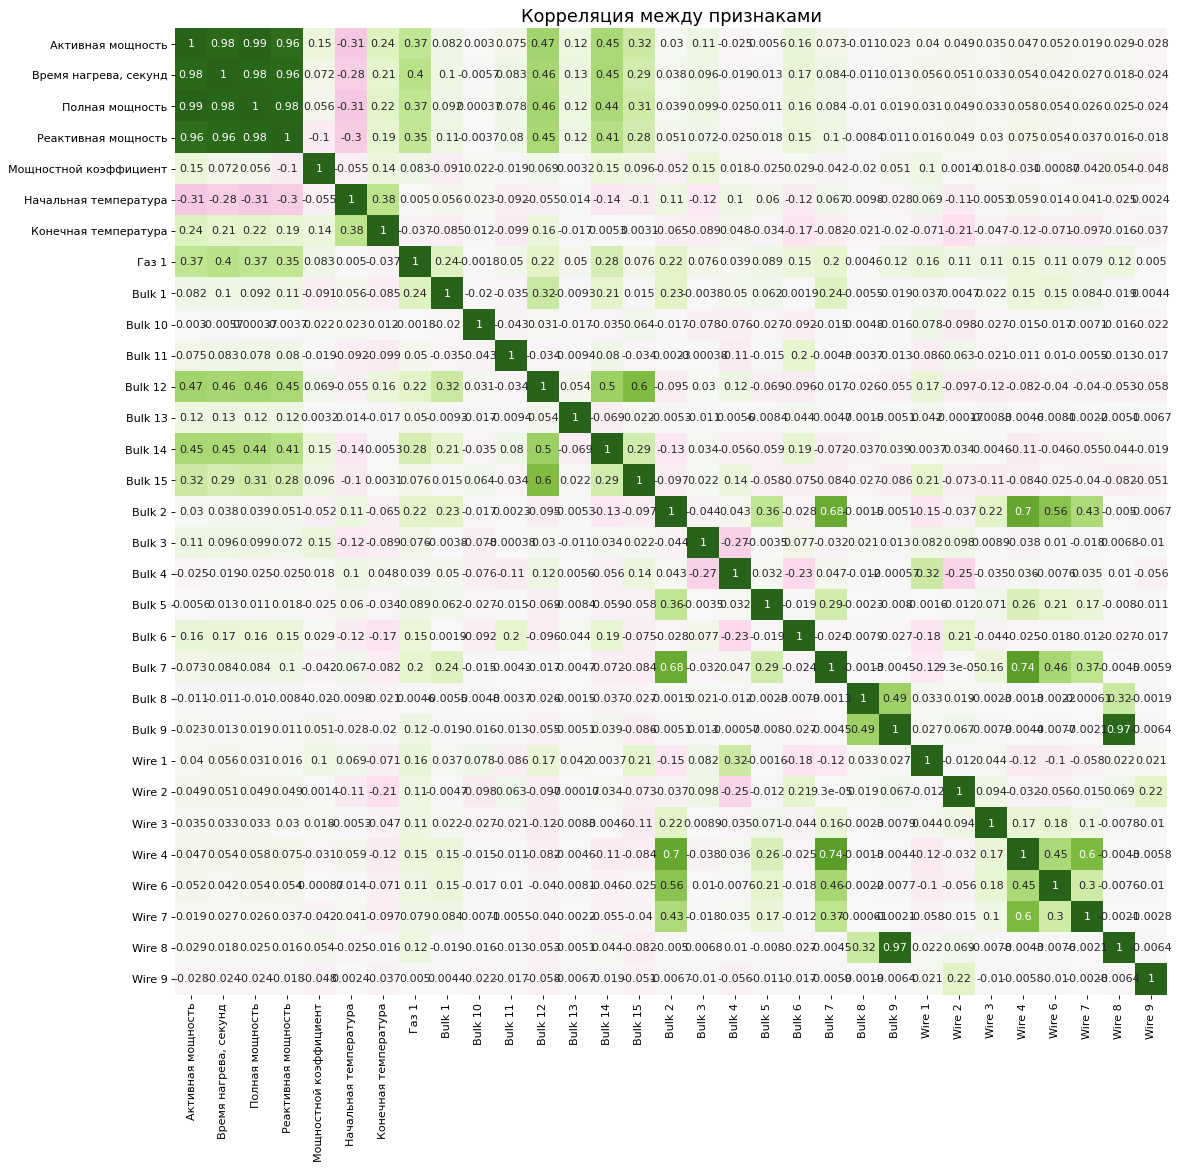

In [343]:
show_correlation(data_final)

Удалим, колонки с низким коэффициентом корреляции.

In [344]:
corr_table = data_final.corr()
delete_column = list(corr_table[(corr_table['Конечная температура'] > -0.05) & 
                                 (corr_table['Конечная температура'] < 0.05)].index)

In [345]:
data_final = data_final.drop(delete_column, axis=1)

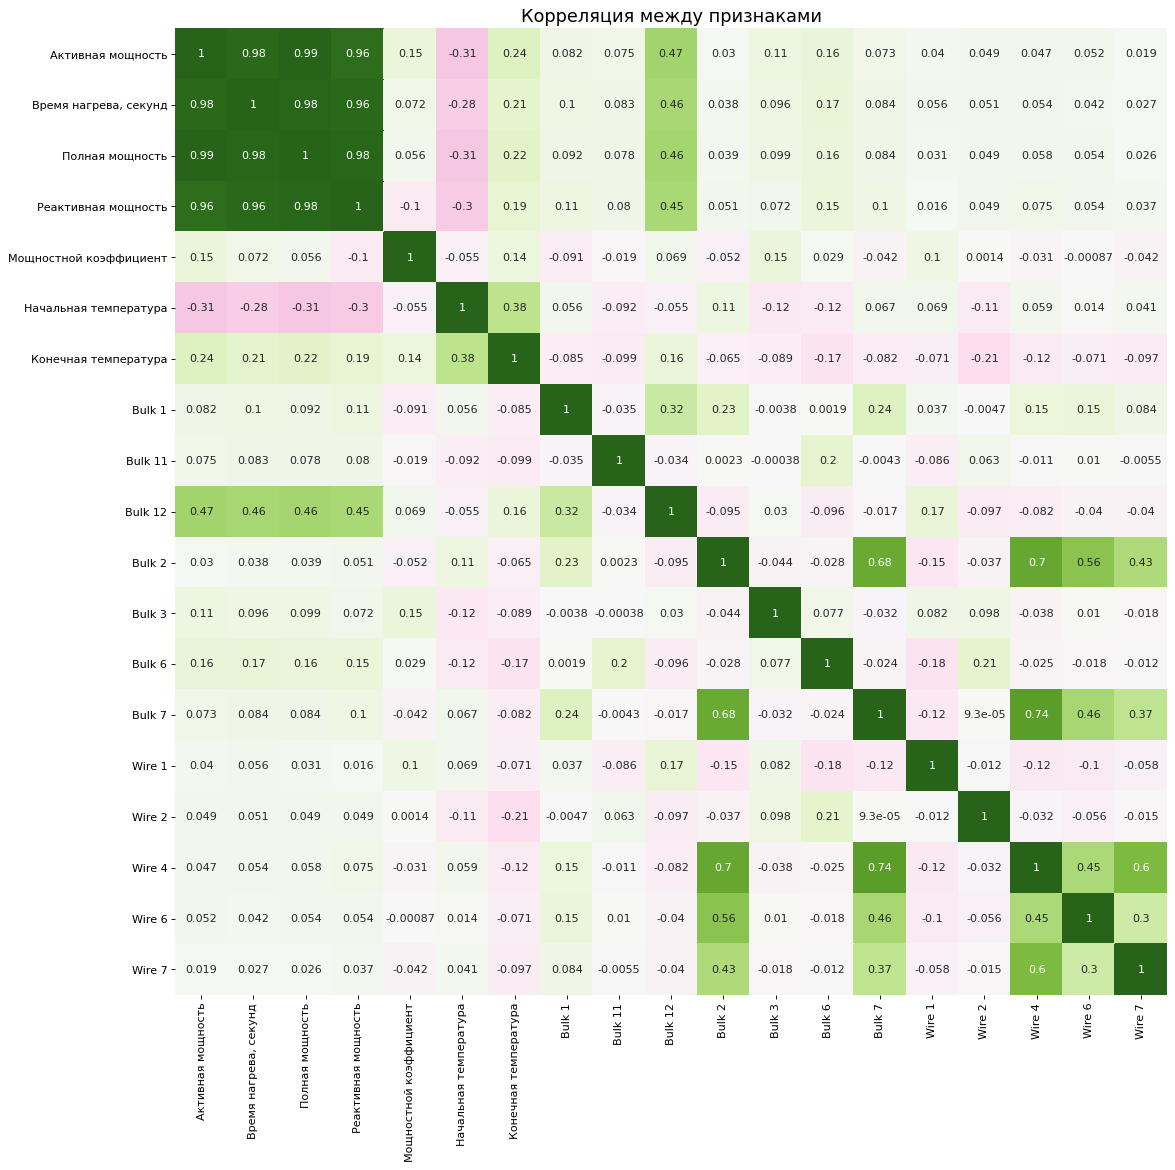

In [346]:
show_correlation(data_final)

##### Вывод по разделу
<a id="id_conclusion_eda"></a>

Исследованы корреляции данных с конечной температурой.
Удалены колонки с низким коэффициетном корреляции ($-0.05 < \alpha < 0.05$), так как информации они не несут, а модель будет обучиться дольше.


### Обучение и тестирование моделей 
<a id="id_learning"></a>

Выделение целевого признака из датасета.

In [347]:
target = data_final['Конечная температура']
features = data_final.drop('Конечная температура',axis=1)

Разделение данных на тестовую и обучающую выборки

In [348]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            random_state=120922, 
                                                                            shuffle=True, test_size=0.25)

In [349]:
# Проверка на соответсвие размеров выборок
print('Размер тестовой выборки:')
print('features_test:',features_test.shape)
print('target_test:',target_test.shape)

print()
print('Размер обучающей выборки:')
print('features_train:',features_train.shape)
print('target_train:',target_train.shape)

Размер тестовой выборки:
features_test: (610, 18)
target_test: (610,)

Размер обучающей выборки:
features_train: (1830, 18)
target_train: (1830,)


In [350]:
# стандартизация
scaler = StandardScaler()
#scaler.fit(features_train) 
features_train = pd.DataFrame(scaler.fit_transform(features_train),columns=features.columns)
features_test = pd.DataFrame(scaler.transform(features_test),columns=features.columns)

features_test

,Активная мощность,"Время нагрева, секунд",Полная мощность,Реактивная мощность,Мощностной коэффициент,Начальная температура,Bulk 1,Bulk 11,Bulk 12,Bulk 2,Bulk 3,Bulk 6,Bulk 7,Wire 1,Wire 2,Wire 4,Wire 6,Wire 7
0,-0.784563,-0.709706,-0.793940,-0.784694,-0.165775,-0.010112,-0.278642,-0.186343,-0.396468,-0.073734,-0.607075,-0.392268,-0.063478,-0.560193,-0.515322,-0.060311,-0.108574,-0.032593
1,-0.608623,-0.736907,-0.638612,-0.672958,0.396169,0.925535,-0.278642,-0.186343,0.005355,-0.073734,-0.607075,-0.392268,-0.063478,1.443607,-0.515322,-0.060311,-0.108574,-0.032593
2,-0.547944,-0.483031,-0.537873,-0.500383,-0.191598,-0.460609,-0.278642,-0.186343,-1.323252,-0.073734,-0.607075,-0.392268,-0.063478,0.716665,-0.515322,-0.060311,-0.108574,-0.032593
3,-1.081479,-1.147945,-1.098220,-1.097435,0.133817,0.371078,-0.278642,-0.186343,-1.323252,-0.073734,-0.275322,-0.392268,-0.063478,0.890078,0.401376,-0.060311,-0.108574,-0.032593
4,-0.846756,-0.872912,-0.871757,-0.889987,0.238464,0.128502,-0.278642,-0.186343,0.011836,-0.073734,0.998609,-0.392268,-0.063478,-0.412979,-0.515322,-0.060311,-0.108574,-0.032593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,-0.780358,-0.670416,-0.751434,-0.676577,-0.494812,0.163156,-0.278642,-0.186343,0.018317,-0.073734,-0.607075,-0.392268,-0.063478,1.862200,-0.515322,-0.060311,-0.108574,-0.032593
606,0.342207,0.378336,0.369129,0.415432,-0.261694,0.301770,-0.278642,-0.186343,1.489505,-0.073734,0.321833,-0.392268,-0.063478,-0.538130,-0.515322,-0.060311,-0.108574,-0.032593
607,-0.640303,-0.622058,-0.649936,-0.650974,0.071991,1.098803,-0.278642,-0.186343,0.329405,-0.073734,0.374913,-0.392268,-0.063478,0.431694,1.983282,-0.060311,-0.108574,-0.032593
608,-0.190109,-0.198931,-0.187177,-0.165465,-0.125685,-0.079419,-0.278642,-0.186343,0.167380,-0.073734,0.759747,-0.392268,-0.063478,0.344363,-0.515322,-0.060311,-0.108574,-0.032593


##### Константная модель
<a id="id_learn_const"></a>

Сначала применим константную модель, чтобы понимать качесво других моделей.

In [351]:
model_dummy = DummyRegressor(strategy='mean')

model_dummy.fit(features_train, target_train)
prediction_dummy = model_dummy.predict(features_train)

mae_dummy = mean_absolute_error(prediction_dummy,target_train)

In [352]:
print("Оценка модели на обучающей выборке:")
print("\"константная модель\":\t", mae_dummy)

Оценка модели на обучающей выборке:
"константная модель":	 10.340231120666463


#####  Линейная регрессия
<a id="id_learn_linreg"></a>

In [353]:
# LinearRegression
model_lin = LinearRegression()

# разбиение на подвыборки для кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=120922)

# оценка кросс-валидацией
scores = cross_val_score(model_lin, features_train, target_train, cv=kf, scoring='neg_mean_absolute_error') 
mae_lin = sum(scores)/len(scores)

In [354]:
print("Оценка модели на обучающей выборке:")
print("\"линейная регрессия\":\t", abs(mae_lin))

Оценка модели на обучающей выборке:
"линейная регрессия":	 8.067490284102394


##### Случайный лес
<a id="id_learn_forest"></a>

In [355]:
# RandomForestRegressor
parameters_forest = {'max_depth': np.arange(1, 10),
                     'n_estimators': np.arange(1, 50, 5)}

best_forest = GridSearchCV(RandomForestRegressor(random_state=120922), 
                           parameters_forest,
                           verbose = True,
                           cv=kf,
                           scoring='neg_mean_absolute_error')

# обучение
best_forest.fit(features_train, target_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=120922, shuffle=True),
             estimator=RandomForestRegressor(random_state=120922),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46])},
             scoring='neg_mean_absolute_error', verbose=True)

In [356]:
print("Оценка модели на обучающей выборке:")
print("\"случайный лес\":\t", abs(best_forest.best_score_))
print(best_forest.best_params_)

Оценка модели на обучающей выборке:
"случайный лес":	 6.534875162077897
{'max_depth': 9, 'n_estimators': 46}


In [357]:
model_forest = RandomForestRegressor(max_depth=9, n_estimators=46,random_state=120922)
model_forest.fit(features_train, target_train)

RandomForestRegressor(max_depth=9, n_estimators=46, random_state=120922)

##### CatBoostRegressor
<a id="id_learn_catboost"></a>

In [358]:
model_catboost = CatBoostRegressor(loss_function = 'MAE',
                                   iterations=300, 
                                   verbose=False, 
                                   random_state=120922)

model_catboost.fit(features_train, target_train)

# оценка кросс-валидацией
scores = cross_val_score(model_catboost, features_train, target_train, cv=kf, scoring='neg_mean_absolute_error')
mae_catboost = abs(sum(scores)/len(scores))

In [359]:
print("Оценка модели на обучающей выборке:")
print("\"CatBoost Regressor\":\t", mae_catboost)

Оценка модели на обучающей выборке:
"CatBoost Regressor":	 6.302254554119248


##### LightGBMRegressor
<a id="id_learn_lgbm"></a>

In [360]:
import re
features_train = features_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_А-Яа-я]+', '', x))
#features_test = features_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_А-Яа-я]+', '', x))
#target_train = target_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_А-Яа-я]+', '', x))

In [361]:
#features_train

In [288]:
# LightGBMRegressor
parameters = {'max_depth': np.arange(2, 10),
             'n_estimators': np.arange(2, 50)}

best_lgbm = GridSearchCV(LGBMRegressor(random_state=120922), 
                  parameters,
                  verbose = False,
                  cv=kf,
                  scoring='neg_mean_absolute_error')

# обучение
best_lgbm.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=120922, shuffle=True),
             estimator=LGBMRegressor(random_state=120922),
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             scoring='neg_mean_absolute_error', verbose=False)

In [289]:
print("Оценка модели на обучающей выборке:")
print("\"LightGBM Regressor\":\t", abs(best_lgbm.best_score_))
print(best_lgbm.best_params_)

Оценка модели на обучающей выборке:
"LightGBM Regressor":	 6.535693991322208
{'max_depth': 4, 'n_estimators': 49}


In [290]:
model_lgbm = LGBMRegressor(max_depth=9, n_estimators=46,random_state=120922)
model_lgbm.fit(features_train, target_train)

LGBMRegressor(max_depth=9, n_estimators=46, random_state=120922)

### Анализ моделей
<a id="id_learn_analysis"></a>

In [363]:
#score_tabel
score_table = {
    'model':['constant_model', 'linear_regression', 'random_forest', 'catboost','light_gbm'],
    'score_valid':[mae_dummy, abs(mae_lin), abs(best_forest.best_score_), mae_catboost, abs(best_lgbm.best_score_)]
}

df_score_table = pd.DataFrame(score_table)

df_score_table.set_index('model',inplace=True)

df_score_table

,score_valid
model,
constant_model,10.340231
linear_regression,8.067490
random_forest,6.534875
catboost,5.833137
light_gbm,6.535694


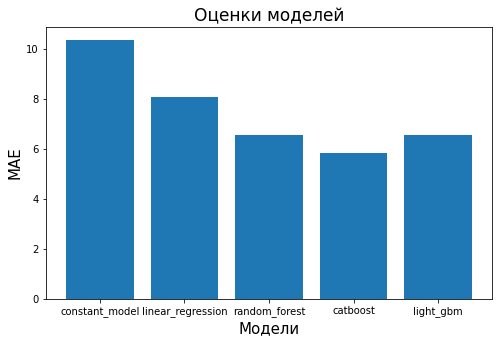

In [364]:
# устанавливаем некоторые параметры рисунка
plt.figure(figsize=[8, 5])

# Рисуем столбчатую диаграму
plt.bar(df_score_table.index, df_score_table['score_valid'])


# Добавляем подписи
plt.title('Оценки моделей', fontsize=17)
plt.xlabel('Модели', fontsize=15)
plt.ylabel('MAE', fontsize=15)
plt.show()


Лучшей моделью оказался Catboost Regressor.
Оценим модель на тестовой выборке:

In [365]:
predictions_catboost = model_catboost.predict(features_test)
mae_catboost = mean_absolute_error(predictions_catboost, target_test) 

print("Оценка модели на тестовой выборке:")
print("\"CatBoost Regressor\":\t", mae_catboost)

Оценка модели на тестовой выборке:
"CatBoost Regressor":	 5.8331365416567005


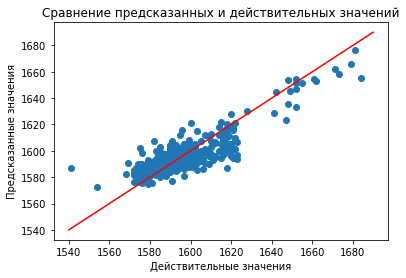

In [366]:
x = [1540, 1690]
y = [1540, 1690]

plt.scatter(target_test, predictions_catboost)
plt.plot(x, y, color='red')

plt.title('Сравнение предсказанных и действительных значений')
plt.xlabel('Действительные значения')
plt.ylabel('Предсказанные значения')

plt.show()

Посмотрим на признаки, которые оказались важны для предсказания температуры для разных моделей.

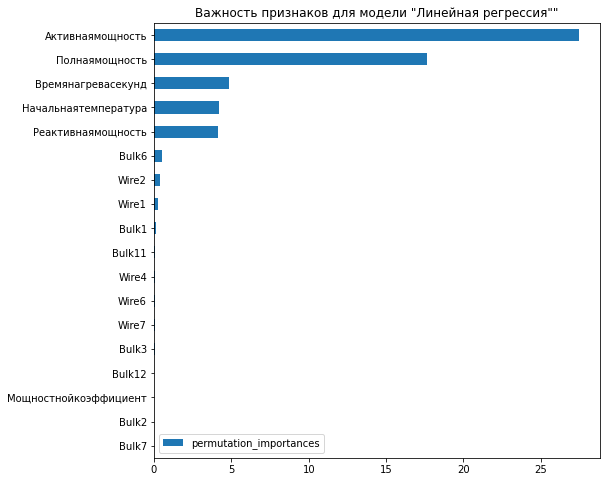

In [367]:
linear_importances = importances(model_lin, 'Линейная регрессия')

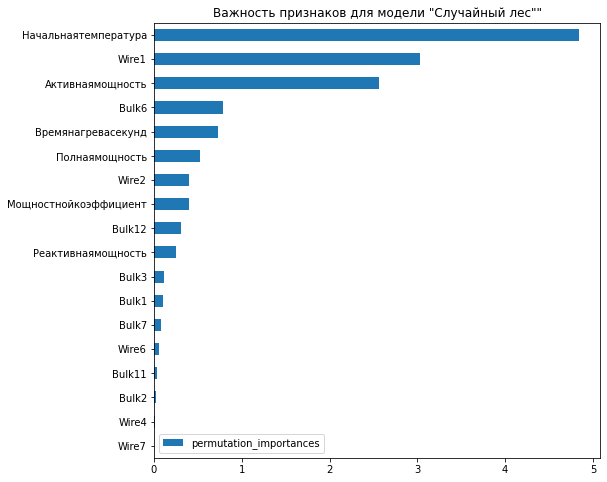

In [368]:
forest_importances = importances(model_forest, 'Случайный лес')

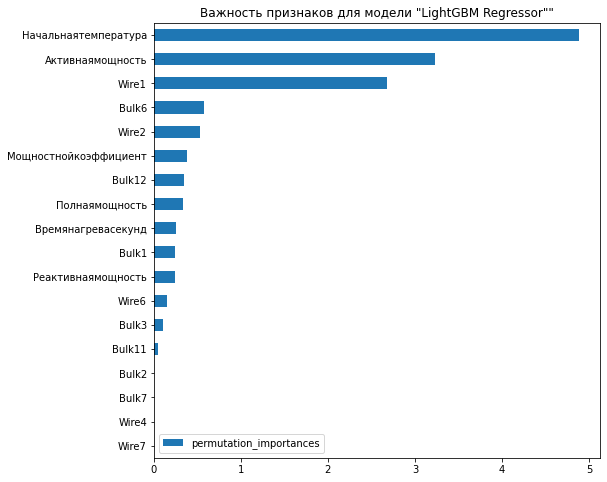

In [369]:
lgbm_importances = importances(model_lgbm, 'LightGBM Regressor')

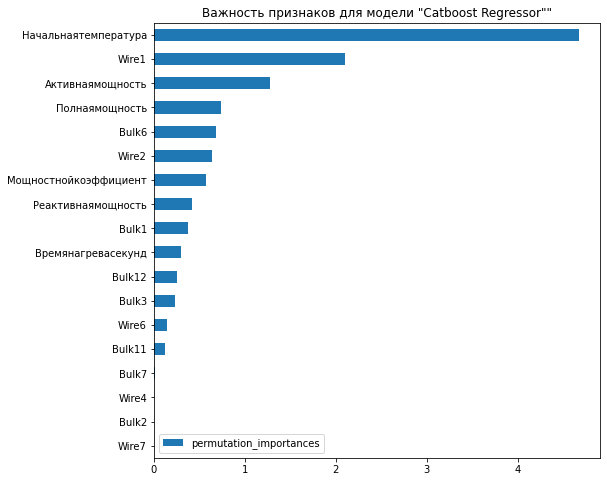

In [370]:
forest_importances = importances(model_catboost, 'Catboost Regressor')

В основном важными признакими для моделей были:
- Начальная температура
- Активная мощность
- Добавка Wire 1
- Добавка Bulk 6
- Добавка Wire 2
- Полная мощность/мощностной коэффициент/время нагрева (в зависимости от модели)

##### Вывод по разделу
<a id="id_conclusion_learn"></a> 

В этом разделе из данных был отобран целевой признак. Все данные поделены на обучающую и тестовую выборки.
Для предсказания температуры стали были обучены модели
- Линейная регрессия
- Случайный лес
- Catboost Regressor
- LightGBM Regressor

Для оценки качесва использовалась MAE (средняя абсолютная ошибка). 
Было проведено сравнение с константной моделью.
Все модели показывают превосходство по сравнению с константной моделью.

Наилучший результат показала модель Catboost Regressor.

    MAE = 5.833
    
Так же были проанализированы признаки играющие ключевую роль для пресказаний.

   В основном важными признакими для моделей были:
- Начальная температура
- Активная мощность
- Добавка Wire 1
- Добавка Bulk 6
- Добавка Wire 2
- Полная мощность/мощностной коэффициент/время нагрева (в зависимости от модели)

### Отчет
<a id="id_report"></a>

В ходе работы были выполнены все запланированные пункты плана:
- Предобработка данных: удалены неполные и нерелевантные данные, обработаны пропуски, исключена лишняя информация, добавлены вспомагательные признаки;
- Исследовательский анализ данных: проанализированны корреляции и исключены признаки со слабым влияением на целевой признак;
- Обучение и тестирование моделей: обучены несколько моделей, проведена проверка на адекватность и сравнение моделей, лучшая модель была протестирована.

На этапе обработки данных были проведены следующие действия
   - удалены партии с одним циклом нагрева в датасете `arc`, одной температурой в датасете `temp` и без продувки газом
   - удалены партии с аномалиями в данных (отрицательной реактивной мощностью и температурами ниже 1400)
   - пропуски в датасетах `bulk` и `wire` заменены на нули
   - добавлены вспомогательные признаки
   
Стоит отметить, что в плане работы добаление новых признаков было в пункте исследовательский анализ данных, но по факту, вспомагательные признаки были добавлены уже на этапе предобработки.   
   
Дополнительными признаками были:
- время нагрева
- мощностной коэффициент 
- полная мощность
   
Следующим шагом была группировка датасетов по номеру партии. 
При группировке были получены следующие дополнительные признаки:
 - суммарная активная мощность
 - суммарная реактивная мощность
 - начальная температура
 - конечная температура (целевой признак)
 - суммарные добавки (по каждой добавке отдельно)
 - суммарное время нагрева в секундах
 - средний мощностной коэффициент 
 - суммарная полная мощность

Основная сложность возникла с группировкой исходных таблиц по номеру партии (не сразу поняла как это делать) и трудность с пониманием какие признаки можно добавить.

Ключевыми шагами в проекте можно выделить:
 - качественных обзор данных, который помог выявить ошибки в сборе данных
 - понимание процесса производсва - непосредственно влияет на предобработку данных
   (например, понимание процесса позволяет понять, что делать с пропущенными значениями)
 - моделирование и оценка моделей

Для предсказания температуры стали были рассмотрены модели: Линейная регрессия, Случайный лес, Catboost Regressor, LightGBM Regressor. Для оценки качесва использовалась MAE (средняя абсолютная ошибка).

По итогам проведения тестов, лучший результат показала модель Catboost Regressor.

    MAE = 5.833
    
Модель была обучена со следующими параметрам:   
- loss_function = 'MAE',
- iterations=300, 
- random_state=120922